# Proyecto 03 - Sistemas de Recomendación

## Dataset: STEAM

**Recuerda descargar el dataset de [aquí](https://github.com/kang205/SASRec). Son dos archivos, uno de calificaciones y otro de información sobre los juegos.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset. Sin embargo, **deberás** modificarlas para hacer un mejor manejo de datos. Algunas cosas a las que deberás prestar atención (tal vez no a todas):
1. Tipos de datos: elige tipos de datos apropiados para cada columna.
2. Descartar columnas poco informativas.
3. Guardar en memoria datasets preprocesados para no tener que repetir código que tarde en correr.

### Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿cuáles son los juegos más populares?¿Y los menos populares?

### Filtro Colaborativo

Deberás implementar un sistema de recomendación colaborativo para este dataset. Ten en cuenta:

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada sus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo.

Puedes implementar un filtro colaborativo a partir de la similitud coseno o índice de Jaccard. ¿Puedes utilizar los métodos de la librería Surprise? Si no es así, busca implementaciones (por ejemplo, nuevas librerías) que sean apropiadas.

Para comenzar a trabajar, puedes asumir que cada entrada es un enlace entre una persona usuaria y un item, **independientemente** de si la crítica es buena o mala. 

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Cómo harías para ponerle un valor a la calificación?
1. ¿Cómo harías para agregar contenido? Por ejemplo, cuentas con el género, precio, fecha de lanzamiento y más información de los juegos.
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

In [1]:
import gzip
import pandas as pd

def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

**Reviews**

In [2]:
contador = 0
data_reviews = []
# Vamos a guardar una de cada 10 reviews para no llenar la memoria RAM. Si pones n = 3, 
# abrira uno de cada tres, y asi.
n = 10
for l in parse('steam_reviews.json.gz'):
    if contador%n == 0:
        data_reviews.append(l)
    else:
        pass
    contador += 1


In [3]:
data_reviews = pd.DataFrame(data_reviews)

In [4]:
data_reviews.head()

,username,hours,products,product_id,page_order,date,text,early_access,page,user_id,compensation,found_funny
0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN
1,Ariman1,13.2,1386.0,328100,2,2017-08-02,Addictive RPG ! Works fine on linux though it ...,False,1,NaN,NaN,NaN
2,freakfantom,0.1,1706.0,725280,5,2017-11-12,Прикольная стрелялка. Взял дешево на распродаже.,False,1,NaN,NaN,NaN
3,The_Cpt_FROGGY,7.8,2217.0,631920,0,2017-12-11,Somewhere on Zibylon:\n~~~~~~~~~~~~~~~~~~\nZib...,False,1,76561198003030375,Product received for free,NaN
4,the_maker988,8.2,18.0,35140,7,2018-01-02,"This game was way to linear for me, and compar...",False,1,76561198353396844,NaN,NaN


In [5]:
data_reviews.to_csv('new_data_reviews.csv')

**Games**

In [6]:
data_games = []
for l in parse('steam_games.json.gz'):
    data_games.append(l)
data_games = pd.DataFrame(data_games)

In [7]:
data_games.head()

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.83,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,False,767400,彼岸领域,NaN,NaN
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",1.79,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,False,773570,NaN,NaN,NaN


In [8]:
data_games.to_csv('new_data_games.csv')

### Análisis Exploratorio de Datos

__Qué es Steam?__  
Steam es un sistema de distribución de juegos multiplataforma en línea, con alrededor de 75 millones de usuarios activos, alrededor de 172 millones de cuentas en total, que aloja más de 3000 juegos, lo que lo convierte en una plataforma ideal para el tipo de trabajo que aquí se presenta. El conjunto de datos contiene registros de más de 3000 juegos y aplicaciones.  

Steam es un servicio de distribución digital de videojuegos de Valve. Se lanzó como un cliente de software independiente en septiembre de 2003 como una forma de que Valve proporcionara actualizaciones automáticas para sus juegos y se expandió para incluir juegos de editores externos. Steam también se ha expandido a una tienda digital móvil y basada en la web en línea.  

De acuerdo con la popularidad del juego, la similitud de la descripción del juego, la calidad del juego y la preferencia del jugador por el juego, recomiendan el juego correspondiente al jugador del juego, de modo que Steam obtenga un mayor grado de satisfacción del cliente.

1. __Se importan las librerías__ necesarias para trabajar en la consigna.

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import pandas as pd

import gc # garbage collector

from surprise import Dataset # convertimos nuestro Dataframe en Dataset
                             # es la estructura de datos que utiliza Surprise!, para almacenar la Matriz de Utilidad
                             # es la forma de almacenar datos con menos memoria, ya que la Matriz de Utilidad es muy grande     
from surprise import Reader # lector de Surprise!
from surprise.model_selection import train_test_split
# quita calificacione de usuario-película de forma aleatoria s/ toda la matriz de utilidad, teniendo cuidado de no quitarle..
# ..todas las calificaciones a un usuario ni a una película

#### DATA REVIEW

1. __Se realiza la carga el dataset__ usando las funcionalidades de Pandas.

In [19]:
new_data_review = pd.read_csv('new_data_reviews.csv')

In [20]:
new_data_review.shape # Filas y columnas

(779307, 13)

* *El Dataset, cuenta con **779.307 Filas**, y **13 Columnas**.*

In [21]:
new_data_review.head(3) # Primeras 3 instancias (filas)

,Unnamed: 0,username,hours,products,product_id,page_order,date,text,early_access,page,user_id,compensation,found_funny
0,0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN
1,1,Ariman1,13.2,1386.0,328100,2,2017-08-02,Addictive RPG ! Works fine on linux though it ...,False,1,NaN,NaN,NaN
2,2,freakfantom,0.1,1706.0,725280,5,2017-11-12,Прикольная стрелялка. Взял дешево на распродаже.,False,1,NaN,NaN,NaN


2. __Valores Faltantes:__ se imprimen en pantalla los nombres de las columnas y cuántos valores faltantes hay por columna. En un principio es a mera exposición, ya que por el momento no vamos a descartar ninguno de ellos,ni realizar imputación de datos.

In [22]:
new_data_review.isnull().sum() # Nombres de las columnas y su cantidad de faltantes

Unnamed: 0           0
username            18
hours             2637
products          1566
product_id           0
page_order           0
date                 0
text              1839
early_access         0
page                 0
user_id         461967
compensation    764719
found_funny     659143
dtype: int64

* *Variables con elementos faltantes:*  
    *1. `compensation` **98%** (764.719);*  
    *2. `found_funny` **86%** (659.143);*  
    *3. `user_id` 59% c/u (461.967);*  
    *4. `hours` 0,3% (2.637);*  
    *5. `text` 0,2% (1.839);*  
    *6. `product` 0,2% (1.566).*

#### DATA GAMES

1. __Se realiza la carga el dataset__ usando las funcionalidades de Pandas.

In [23]:
new_data_games = pd.read_csv('new_data_games.csv')

In [24]:
new_data_games.shape # Filas y columnas

(32135, 17)

* *El Dataset, cuenta con **32.135 Filas**, y **13 Columnas**.*

In [25]:
new_data_games.head(3) # Primeras 3 instancias (filas)

,Unnamed: 0,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,0,Kotoshiro,"['Action', 'Casual', 'Indie', 'Simulation', 'S...",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"['Strategy', 'Action', 'Indie', 'Casual', 'Sim...",4.49,http://steamcommunity.com/app/761140/reviews/?...,['Single-player'],4.99,False,761140.0,Kotoshiro,NaN,NaN
1,1,"Making Fun, Inc.","['Free to Play', 'Indie', 'RPG', 'Strategy']",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"['Free to Play', 'Strategy', 'Indie', 'RPG', '...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"['Single-player', 'Multi-player', 'Online Mult...",Free To Play,False,643980.0,Secret Level SRL,Mostly Positive,NaN
2,2,Poolians.com,"['Casual', 'Free to Play', 'Indie', 'Simulatio...",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"['Free to Play', 'Simulation', 'Sports', 'Casu...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"['Single-player', 'Multi-player', 'Online Mult...",Free to Play,False,670290.0,Poolians.com,Mostly Positive,NaN


2. __Valores Faltantes:__ se imprimen en pantalla los nombres de las columnas y cuántos valores faltantes hay por columna. En un principio es a mera exposición, ya que por el momento no vamos a descartar ninguno de ellos,ni realizar imputación de datos.

In [26]:
new_data_games.isnull().sum() # Nombres de las columnas y su cantidad de faltantes

Unnamed: 0            0
publisher          8062
genres             3283
app_name              2
title              2050
url                   0
release_date       2067
tags                163
discount_price    31910
reviews_url           2
specs               670
price              1377
early_access          0
id                    2
developer          3299
sentiment          7182
metascore         29528
dtype: int64

* *Casi todos las Variables tienen elementos faltantes. Detallamos las principales:*  
    *1. `discount_price` **98%** (31.910);*  
    *2. `metascore` **98%** (29.528);*  
    *3. `publisher` 59% c/u (8.062);*  
    *4. `sentiment` 0,3% (7.182);*  
    *5. `developer` 0,2% (3.299);*  
    *6. `genres` 0,2% (3.283).*
    
* *Cabe aclarar que el `id` de los juegos, tienen 2 valores faltantes.*
* *`metascore` refiere a la media de todas las reseñas recibidas para dicho juego.*

In [85]:
new_data_games[data_games.id == '35140']

,Unnamed: 0,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
31617,31617,"Warner Bros. Interactive Entertainment, Feral ...","['Action', 'Adventure']",Batman: Arkham Asylum Game of the Year Edition,Batman: Arkham Asylum Game of the Year Edition,http://store.steampowered.com/app/35140/Batman...,2010-03-26,"['Action', 'Batman', 'Stealth', 'Adventure', '...",NaN,http://steamcommunity.com/app/35140/reviews/?b...,"['Single-player', 'Steam Achievements', 'Steam...",19.99,False,35140.0,"Rocksteady Studios,Feral Interactive (Mac)",Overwhelmingly Positive,91.0


#### 3 DATA COMBINADA

1. __Se realiza la carga el dataset__ usando las funcionalidades de Surprise.

In [34]:
reader = Reader()

In [40]:
frames = [new_data_review, new_data_games]

In [44]:
combined = pd.concat(frames)
combined.head(3)

,Unnamed: 0,username,hours,products,product_id,page_order,date,text,early_access,page,...,release_date,tags,discount_price,reviews_url,specs,price,id,developer,sentiment,metascore
0,0,Chaos Syren,0.1,41.0,725280.0,0.0,2017-12-17,This would not be acceptable as an entertainme...,False,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Ariman1,13.2,1386.0,328100.0,2.0,2017-08-02,Addictive RPG ! Works fine on linux though it ...,False,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,freakfantom,0.1,1706.0,725280.0,5.0,2017-11-12,Прикольная стрелялка. Взял дешево на распродаже.,False,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


2. __Se responden las siguientes preguntas:__

1. ¿Cuántos usuarios únicos hay?

In [45]:
print(len(combined['username'].unique()))

540339


* 470758 usuarios calificaron películas.

2. ¿Cuántos tipos de calificaciones hay (`sentiment`)?

In [50]:
pd.unique(combined['sentiment'])

array([nan, 'Mostly Positive', 'Mixed', '1 user reviews',
       '3 user reviews', '8 user reviews', 'Very Positive',
       'Overwhelmingly Positive', '6 user reviews', '5 user reviews',
       '2 user reviews', 'Very Negative', 'Positive', 'Mostly Negative',
       '9 user reviews', 'Negative', '4 user reviews', '7 user reviews',
       'Overwhelmingly Negative'], dtype=object)

In [51]:
print(combined['sentiment'].value_counts())

Mixed                      4103
Very Positive              3868
Positive                   3281
Mostly Positive            2744
1 user reviews             2496
2 user reviews             1756
3 user reviews             1231
4 user reviews              964
5 user reviews              846
Mostly Negative             802
6 user reviews              756
7 user reviews              619
8 user reviews              537
9 user reviews              488
Overwhelmingly Positive     303
Negative                    123
Very Negative                29
Overwhelmingly Negative       7
Name: sentiment, dtype: int64


Text(0.5, 1.0, 'Número de Calificaciones por Tipo')

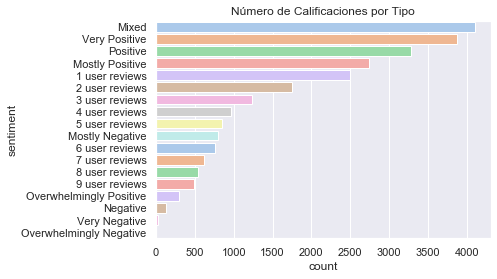

In [52]:
sns.countplot(data = combined, y = 'sentiment', order = combined['sentiment'].value_counts().index, palette='pastel')
plt.title('Número de Calificaciones por Tipo')

3. ¿Cuántos juegos calificó cada usuario?

In [53]:
df1_by_users = combined.groupby(['sentiment']).count()
df1_by_users.head()

# Vemos cuántas calificaciones de juego realizó cada usuario

,Unnamed: 0,username,hours,products,product_id,page_order,date,text,early_access,page,...,url,release_date,tags,discount_price,reviews_url,specs,price,id,developer,metascore
sentiment,,,,,,,,,,,,,,,,,,,,,
1 user reviews,2496,0,0,0,0,0,0,0,2496,0,...,2496,2348,2483,18,2496,2432,2424,2496,2206,10
2 user reviews,1756,0,0,0,0,0,0,0,1756,0,...,1756,1633,1745,14,1756,1693,1692,1756,1554,12
3 user reviews,1231,0,0,0,0,0,0,0,1231,0,...,1231,1127,1223,11,1231,1186,1186,1231,1070,8
4 user reviews,964,0,0,0,0,0,0,0,964,0,...,964,882,960,7,964,946,931,964,851,7
5 user reviews,846,0,0,0,0,0,0,0,846,0,...,846,771,836,5,846,819,817,846,738,6


In [72]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
combined['sentiment'] = lb_make.fit_transform(combined['sentiment'])
print(combined['sentiment'])

0         0
1         0
2         0
3         0
4         0
         ..
32130     0
32131     0
32132     0
32133     1
32134    16
Name: sentiment, Length: 811442, dtype: int64


In [74]:
combined.head()

,Unnamed: 0,username,hours,products,product_id,page_order,date,text,early_access,page,...,release_date,tags,discount_price,reviews_url,specs,price,id,developer,sentiment,metascore
0,0,Chaos Syren,0.1,41.0,725280.0,0.0,2017-12-17,This would not be acceptable as an entertainme...,False,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
1,1,Ariman1,13.2,1386.0,328100.0,2.0,2017-08-02,Addictive RPG ! Works fine on linux though it ...,False,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
2,2,freakfantom,0.1,1706.0,725280.0,5.0,2017-11-12,Прикольная стрелялка. Взял дешево на распродаже.,False,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
3,3,The_Cpt_FROGGY,7.8,2217.0,631920.0,0.0,2017-12-11,Somewhere on Zibylon:\n~~~~~~~~~~~~~~~~~~\nZib...,False,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
4,4,the_maker988,8.2,18.0,35140.0,7.0,2018-01-02,"This game was way to linear for me, and compar...",False,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN


3. ¿Cómo es la distribución de las calificaciones?¿Pueden concluir algo de ese gráfico?

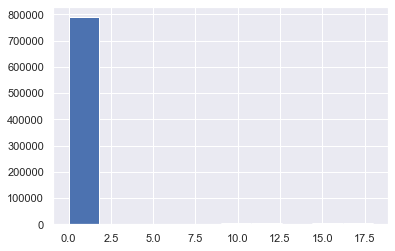

In [73]:
combined['sentiment'].hist()
plt.show()

* El mayor número de calificaciones, está alrededor de 4, seguidas de 3, seguidas de 5.

4. ¿Cómo es la distribución del número de calificaciones por usuario?

In [76]:
calificaciones_por_usuario = combined.username.value_counts() # Vemos por usuario, el conteo de dichas calificaciones
calificaciones_por_usuario # 1er columnas es el ID del usuario, la segunda, la cantidad de calificaciones que dió

123                         213
Alex                        190
Chris                       155
Nick                        143
Matt                        137
                           ... 
Mconk1515                     1
Jim toungebottom the 8th      1
Squanjo                       1
m⊕⊕- m⊕⊕                      1
Pantalloons                   1
Name: username, Length: 540338, dtype: int64

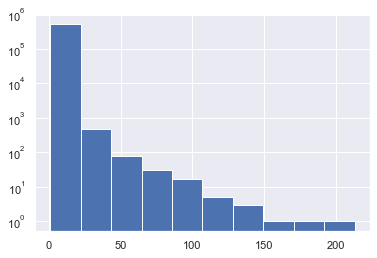

In [77]:
calificaciones_por_usuario.hist(log = True)

* Es el mismo que hicimos arriba, de cantidad de usuarios con más calificaciones.

5. ¿Cuál es el juego con más calificaciones?¿Cuántas tiene?¿Y la que menos calificaciones tiene?

In [81]:
#juegos_por_vistos = combined.id.value_counts() # Hacemos un conteo por película, de los valores únicos por película (para c/ Id de película, cuántos hay)
#juegos_por_vistos.index = combined.loc[juegos_por_vistos.index] # Obtenemos con índice que lo relacionamos con el título, para poder llenar el nombre
#juegos_por_vistos # La película más calificada es Piratas del Caribe

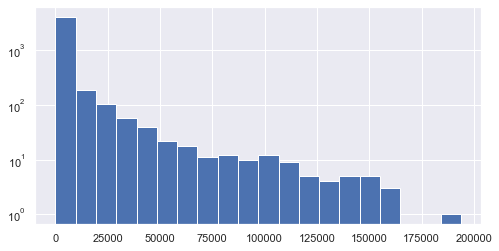

In [30]:
#plt.figure(figsize = (8,4))
#peliculas_por_vistos.hist(log = True, bins = 20)
#plt.show()

* Son pocas las películas que tienen altas calificaciones.
* Hay bastantes películas que tienen pocas calificaciones.

### Entrenamiento

In [83]:
data = Dataset.load_from_df(combined[['username', 'product_id','metascore']], reader)

In [84]:
trainset, testset = train_test_split(data, test_size=.25) # OJO! Es el de Surprise. Es un Split del Dataset Completo

Vamos a entrenar un algoritmo SVD. Explorar sus parámetros y su funcionamiento.

In [86]:
from surprise import SVD # OJO! Es también es de Surprise!
algo = SVD() # Usamos los hiperparámetros predeterminados

Entrenamos sobre el `trainset`

In [87]:
algo.fit(trainset)

# Entrenamos la Matriz de Utilidad de Train y de Test
# No hay y
# Entrena SVD sobre toda la Matriz de Utilidad (No s/ X e y)

Y predecimos sobre el `testset`. Notar que para predecir sobre un conjunto de test se usa la función `test`.

In [88]:
predictions = algo.test(testset)

Explorar las característica de `predictions` y alguno de sus elementos

In [89]:
predictions[1] # Predicción para 1 (para un usuario en particular)

# uid: Id del Usuario
# iid: Id del juego
# r_ui: calificación que le da a ese juego en particular (la conocida)
# est: estimación de la calificación (obtenida de SVD)
# was imposible = False: fue posible calificar el juego

Prediction(uid='GodHellios', iid=313340.0, r_ui=nan, est=5, details={'was_impossible': False})

En cambio, si queremos predecir para un usuario y una película en particular, usamos la función `predict`

In [90]:
algo.predict(132894,28)

Prediction(uid=132894, iid=28, r_ui=None, est=5, details={'was_impossible': False})

* r_ui=None: El usuario no la calificó dicho juego.